In [1]:
# Enable autoreload extension to automatically reload modules
%load_ext autoreload
%autoreload 1

# Import necessary modules and libraries
from AirSeaFluxCode import AirSeaFluxCode  # Import AirSeaFluxCode class from AirSeaFluxCode module
import xarray as xr  # Import xarray library with alias xr
import gsw_xarray as gsw  # Import gsw_xarray module with alias gsw
import matplotlib.dates as mdates  # Import module for working with dates in matplotlib
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting
import numpy as np  # Import numpy library with alias np for numerical operations
import cartopy.crs as ccrs  # Import cartopy for geospatial data visualization
import cmocean.cm as cmo  # Import colormaps from cmocean for oceanography
from matplotlib.lines import Line2D
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter
from tqdm.notebook import tqdm_notebook as tqdm
import cartopy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

RuntimeWarning
# Import my_funcs module for interactive reloading
%aimport my_funcs

# Call update_params function from my_funcs module to update parameters
my_funcs.update_params(fontsize=24)

# Define a function to customize x-axis ticks on a plot
def fix_xticks(ax):
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to display month
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))  # Format major ticks as abbreviated month (e.g., Jan)
    # Set x-axis label to '2019'
    ax.set_xlabel('2019')
    

# Define color variables with hexadecimal color codes
c20 = "#C13F89"  # Define color c20
c22 = "#3ec177"  # Define color c22
c23 = "#3e88c1"  # Define color c23
ext = "#a43ec1"  # Define color ext

# Manually create Line2D objects for legend handles
legend_handles = [
    Line2D([], [], color=c20, lw=3, label='SD1020'),
    Line2D([], [], color=c22, lw=3, label='SD1022'),
    Line2D([], [], color=c23, lw=3, label='SD1023')
]

def km_formatter(x, pos):
    return f'{x / 1000:.0f} km'

In [2]:
ds20 = xr.open_dataset("../data/sd1020_5min.nc")
ds22 = xr.open_dataset("../data/sd1022_5min.nc")
ds23 = xr.open_dataset("../data/sd1023_5min.nc")

km20 = xr.open_dataset("../data/sd1020_5min_1km.nc")
km22 = xr.open_dataset("../data/sd1022_5min_1km.nc")
km23 = xr.open_dataset("../data/sd1023_5min_1km.nc")

In [3]:
def calc_tasf(ds,SST,n):

        # Convert ship data into NumPy arrays
    lat  = np.asarray(ds["latitude"])              # Latitude
    spd  = np.asarray(ds["wind_speed"])            # Wind speed
    t    = np.asarray(ds["TEMP_AIR_MEAN"])         # Air temperature
    sst  = np.asarray(ds[SST])                     # Sea surface temperature
    rh   = np.asarray(ds["RH_MEAN"])               # Relative humidity
    
    # Initialize a constant
    hin  = 17  # Height of the sensors (17 meters)
    
    # Calculate temperature at 2 meters above the sea surface ('t10n') and relative and specific humidity at 2 meters above the sea surface ('rh','q10n')
    
    air_hum = AirSeaFluxCode(spd, 
                             t, 
                             sst, 
                             "skin", 
                             meth = "C35", 
                             lat = lat, 
                             hin = [3.68,2.5,2.5], 
                             hout = 10,
                             hum=["rh", rh], 
                             out_var = ["tref","rh", "qref",'qair','qsea',"uref",'latent','sensible'])
    
    # # Calculate horizontal wind speed at 10 meters above the sea surface ('u10n')
    # wind = AirSeaFluxCode(spd, 
    #                       t, 
    #                       sst, 
    #                       "skin", 
    #                       meth = "C35", 
    #                       lat = lat, 
    #                       hin = [3.68,2.5,2.5], 
    #                       hout = 10,
    #                       out_var = ["uref",'latent','sensible'])
    
    
    
    # Assign the calculated temperature values (converted to degrees Celsius) at 2 meters above the sea surface to the 't2m' column
    ds['t2m'] = (list(ds.dims)[0]), air_hum['tref'] - 273.15
    
    # Assign the calculated horizontal wind speed values at 10 meters above the sea surface to the 'u10' column
    ds['u10'] = (list(ds.dims)[0]), air_hum['uref']
    
    # Assign the calculated specific humidity values at 2 meters above the sea surface (converted to g/kg) to the 'qref' column
    ds['rh_corr'] = (list(ds.dims)[0]), air_hum['rh']
    ds['qref'] = (list(ds.dims)[0]), air_hum['qref']*1000
    ds['qair'] = (list(ds.dims)[0]), air_hum['qair']*1000
    ds['qsea'] = (list(ds.dims)[0]), air_hum['qsea']*1000
    
    # Assign some flags or indicators to the 'flags' column
    ds['flags'] = (list(ds.dims)[0]), air_hum['flag']
    
    # Assign some flags or indicators to the 'flags' column
    ds[f'sensible_{n}'] = (list(ds.dims)[0]), air_hum['sensible']
    ds[f'latent_{n}'] = (list(ds.dims)[0]), air_hum['latent']

    return ds

In [4]:
ds20 = calc_tasf(ds20,"TEMP_IR_SEA_WING_UNCOMP_MEAN",2)
ds22 = calc_tasf(ds22,"TEMP_IR_UNCOR_MEAN",2)
ds23 = calc_tasf(ds23,"TEMP_IR_UNCOR_MEAN",2)

ds20["tasf"] = ('time'), ds20['latent'].values + ds20['sensible'].values
ds22["tasf"] = ('time'), ds22['latent'].values + ds22['sensible'].values
ds23["tasf"] = ('time'), ds23['latent'].values + ds23['sensible'].values

ds20["tasf_2"] = ('time'), ds20['latent_2'].values + ds20['sensible_2'].values
ds22["tasf_2"] = ('time'), ds22['latent_2'].values + ds22['sensible_2'].values
ds23["tasf_2"] = ('time'), ds23['latent_2'].values + ds23['sensible_2'].values

ds20["longitude"] = ('time'), ((ds20.lon.values + 180) % 360) - 180
ds22["longitude"] = ('time'), ((ds22.lon.values + 180) % 360) - 180
ds23["longitude"] = ('time'), ((ds23.lon.values + 180) % 360) - 180

In [5]:
km20 = calc_tasf(km20,"TEMP_IR_SEA_WING_UNCOMP_MEAN",2)
km22 = calc_tasf(km22,"TEMP_IR_UNCOR_MEAN",2)
km23 = calc_tasf(km23,"TEMP_IR_UNCOR_MEAN",2)

km20["tasf"] = ('distance'), km20['latent'].values + km20['sensible'].values
km22["tasf"] = ('distance'), km22['latent'].values + km22['sensible'].values
km23["tasf"] = ('distance'), km23['latent'].values + km23['sensible'].values

km20["tasf_2"] = ('distance'), km20['latent_2'].values + km20['sensible_2'].values
km22["tasf_2"] = ('distance'), km22['latent_2'].values + km22['sensible_2'].values
km23["tasf_2"] = ('distance'), km23['latent_2'].values + km23['sensible_2'].values

km20["longitude"] = ('distance'), ((km20.lon.values + 180) % 360) - 180
km22["longitude"] = ('distance'), ((km22.lon.values + 180) % 360) - 180
km23["longitude"] = ('distance'), ((km23.lon.values + 180) % 360) - 180

In [6]:
ds20h = ds20.resample(time='12H').mean('time')
ds22h = ds22.resample(time='12H').mean('time')
ds23h = ds23.resample(time='12H').mean('time')

ds20h["longitude"] = ('time'), ((ds20h.lon.values + 180) % 360) - 180
ds22h["longitude"] = ('time'), ((ds22h.lon.values + 180) % 360) - 180
ds23h["longitude"] = ('time'), ((ds23h.lon.values + 180) % 360) - 180

In [7]:
# Create lists to store variables for zipping
datasets = [ds20, ds22, ds23]
datasetsh = [ds20h, ds22h, ds23h]
datasetskm = [km20, km22, km23]
labels = ["SD1020", "SD1022", "SD1023"]
colors = [c20, c22, c23]

In [8]:
def add_map_stuff(ax):
    ax.add_feature(cartopy.feature.LAND, color='0.8',zorder=2)
    gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None, color='darkgrey',zorder=1)
    gl.n_steps = 90
    ax.coastlines(zorder=3)

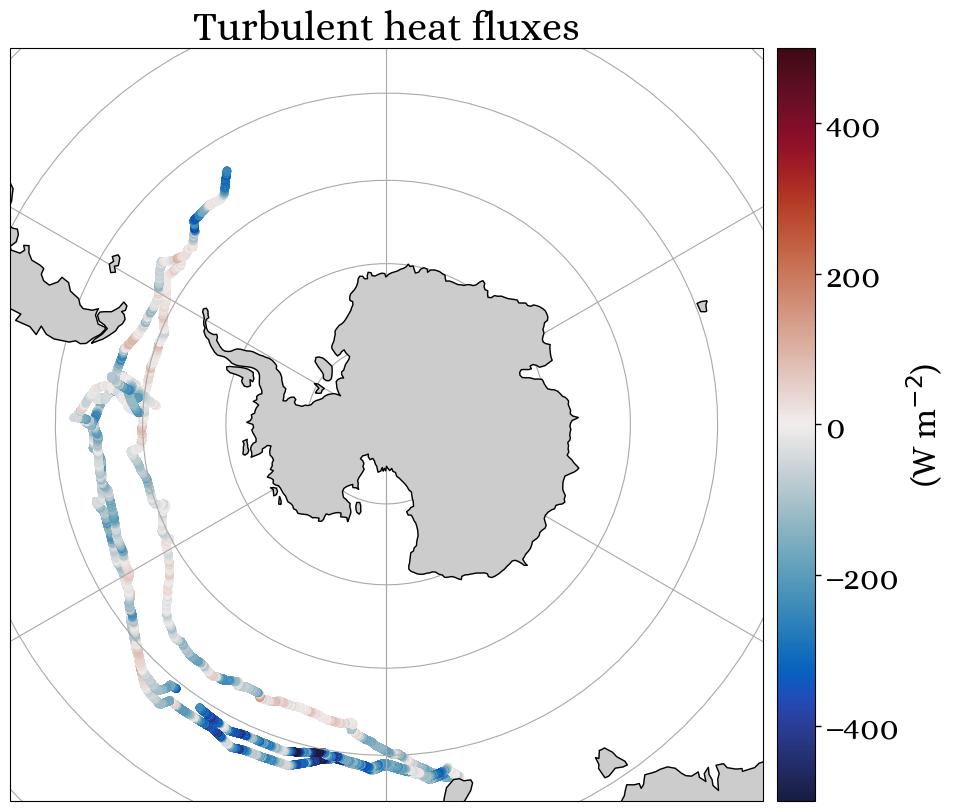

In [9]:
# Create a figure and a gridspec with two rows and two columns
fig, ax = plt.subplots(1,1,figsize=(16,8),constrained_layout=True,subplot_kw={'projection':ccrs.SouthPolarStereo()})

add_map_stuff(ax)

for ds,l,c in zip(datasets,labels,colors):
    
    sct = ds.plot.scatter(ax=ax,
                          x='longitude',
                          y='latitude', 
                          hue='tasf', 
                          ec="None", 
                          cmap="cmo.balance",
                          vmin=-500,
                          vmax=500,
                          label=l,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs={'pad':0.01,'label':'(W m$^{-2}$)','aspect':20},
                          add_colorbar=True if "1020" in l else False)

ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
ax.set(title="Turbulent heat fluxes")
plt.show()

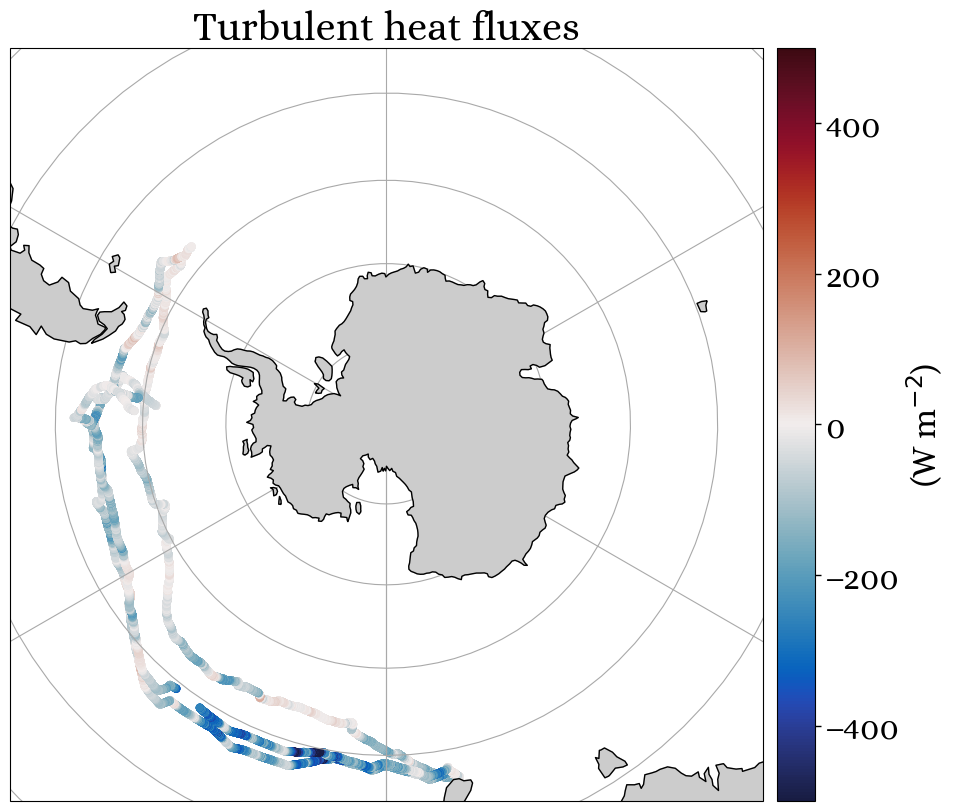

In [10]:
# Create a figure and a gridspec with two rows and two columns
fig, ax = plt.subplots(1,1,figsize=(16,8),constrained_layout=True,subplot_kw={'projection':ccrs.SouthPolarStereo()})

add_map_stuff(ax)

for ds,l,c in zip(datasetskm,labels,colors):
    
    sct = ds.plot.scatter(ax=ax,
                          x='longitude',
                          y='latitude', 
                          hue='tasf_2', 
                          ec="None", 
                          cmap="cmo.balance",
                          vmin=-500,
                          vmax=500,
                          label=l,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs={'pad':0.01,'label':'(W m$^{-2}$)','aspect':20},
                          add_colorbar=True if "1020" in l else False)

ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
ax.set(title="Turbulent heat fluxes")
plt.show()

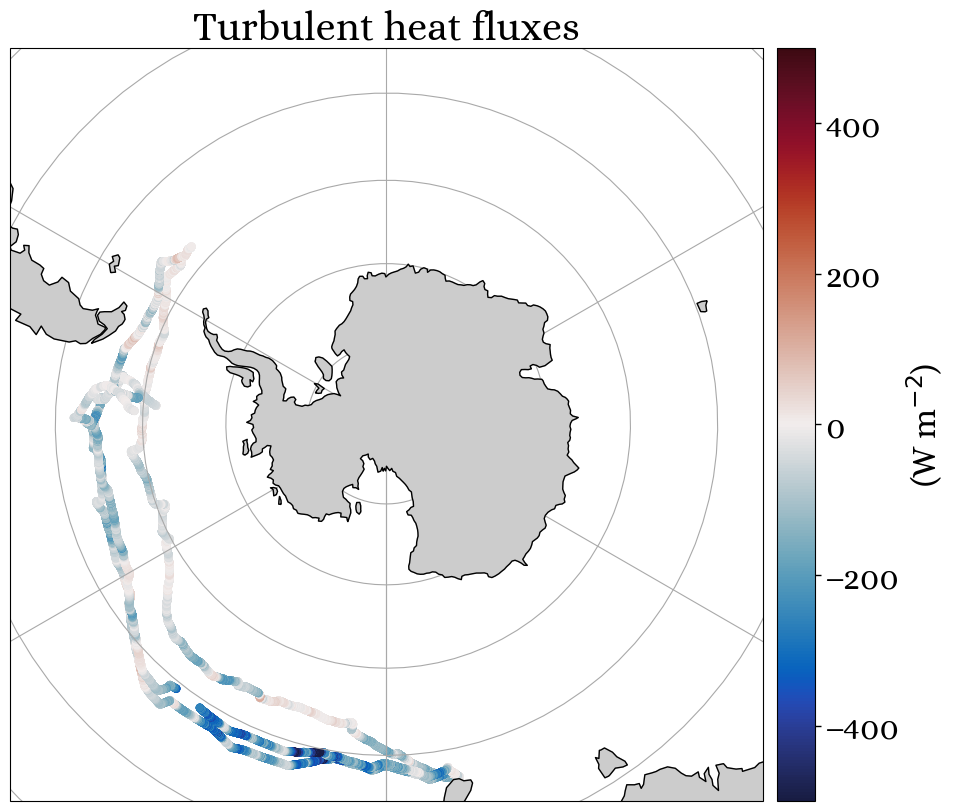

In [11]:
# Create a figure and a gridspec with two rows and two columns
fig, ax = plt.subplots(1,1,figsize=(16,8),constrained_layout=True,subplot_kw={'projection':ccrs.SouthPolarStereo()})

add_map_stuff(ax)

for ds,l,c in zip(datasetskm,labels,colors):
    
    sct = ds.plot.scatter(ax=ax,
                          x='longitude',
                          y='latitude', 
                          hue='tasf_2', 
                          ec="None", 
                          cmap="cmo.balance",
                          vmin=-500,
                          vmax=500,
                          label=l,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs={'pad':0.01,'label':'(W m$^{-2}$)','aspect':20},
                          add_colorbar=True if "1020" in l else False)

ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
ax.set(title="Turbulent heat fluxes")
plt.show()

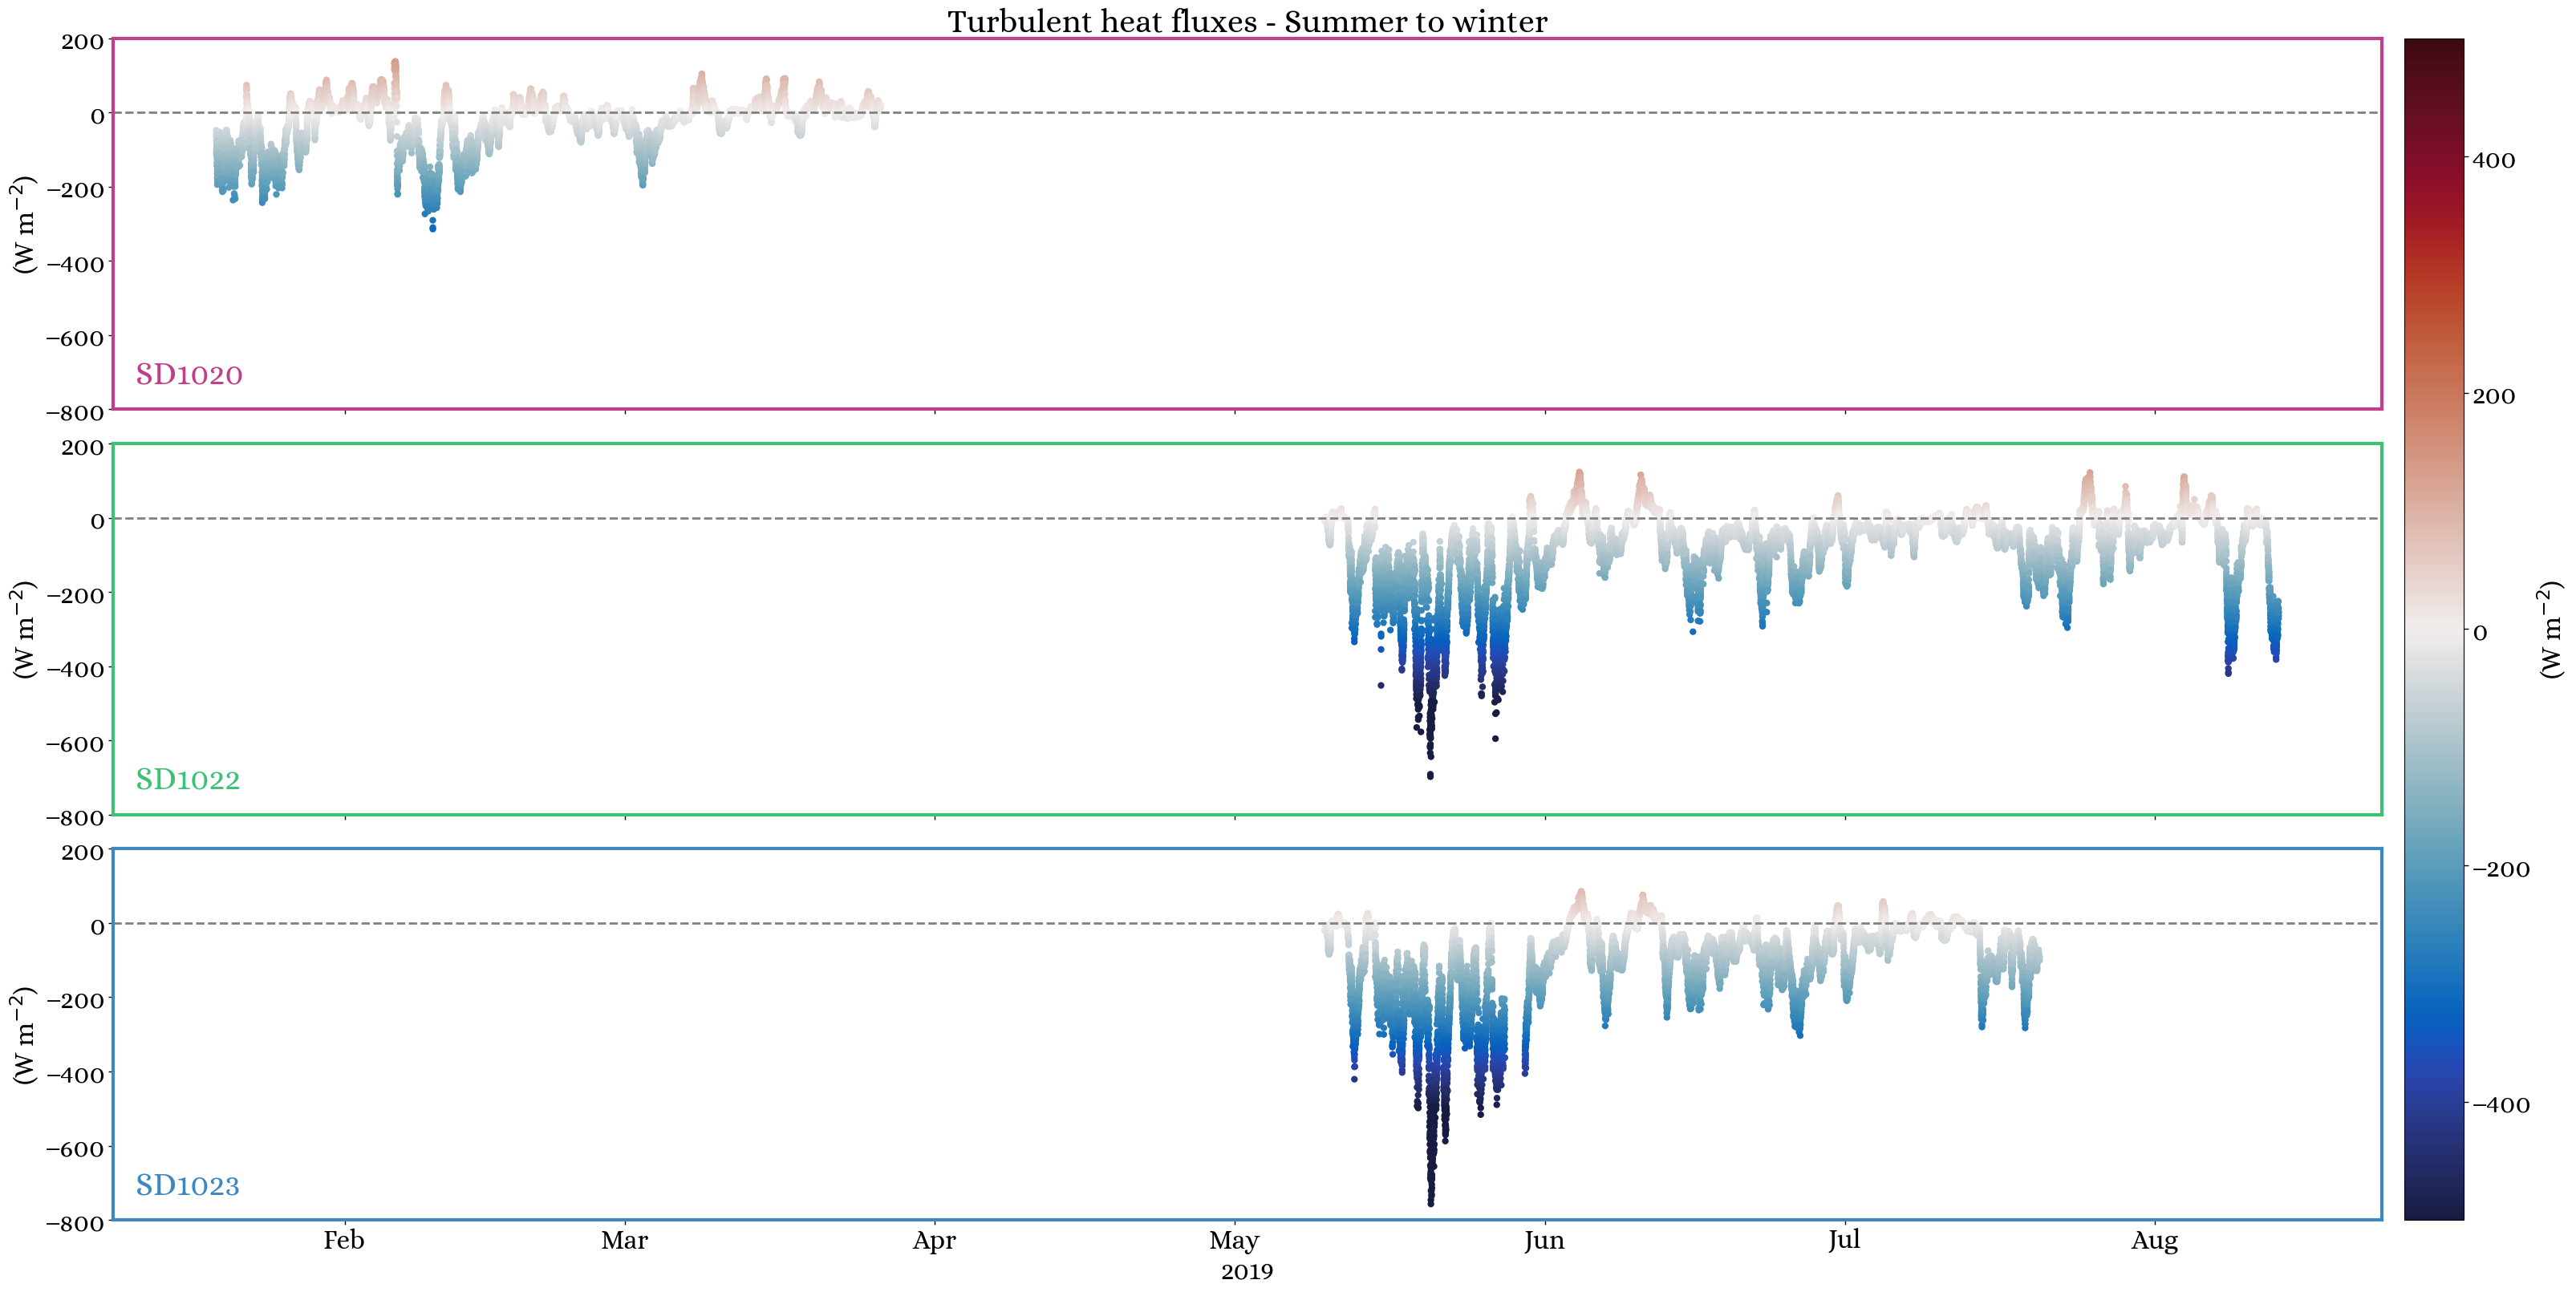

In [13]:
# Create a figure and a gridspec with two rows and two columns
fig, ax = plt.subplots(3,1,figsize=(32,16),constrained_layout=True,sharex=True)

for axs,ds,l,c in zip(ax,datasets,labels,colors):
    
    axs.axhline(0,ls='--',lw=2,c='grey')
    sct = ds.plot.scatter(ax=axs,
                          x='time',
                          y='tasf', 
                          hue='tasf', 
                          ec="None", 
                          cmap="cmo.balance",
                          vmin=-500,
                          vmax=500,
                          add_colorbar=False)
    
    axs.set(xlabel="",
            ylabel="(W m$^{-2}$)",
            ylim=(-800,200))
    axs.set_title(l,loc='left',y=0.05,x=0.01,c=c)
    for spine in axs.spines.values():
        spine.set_color(c)
        spine.set_linewidth(3)

fix_xticks(axs)
my_funcs.rot_ticks(axs,0,ha='center')

ax[0].set_title('Turbulent heat fluxes - Summer to winter')
plt.colorbar(sct,ax=ax,**{'pad':0.01,'label':'(W m$^{-2}$)','aspect':20})
plt.show()

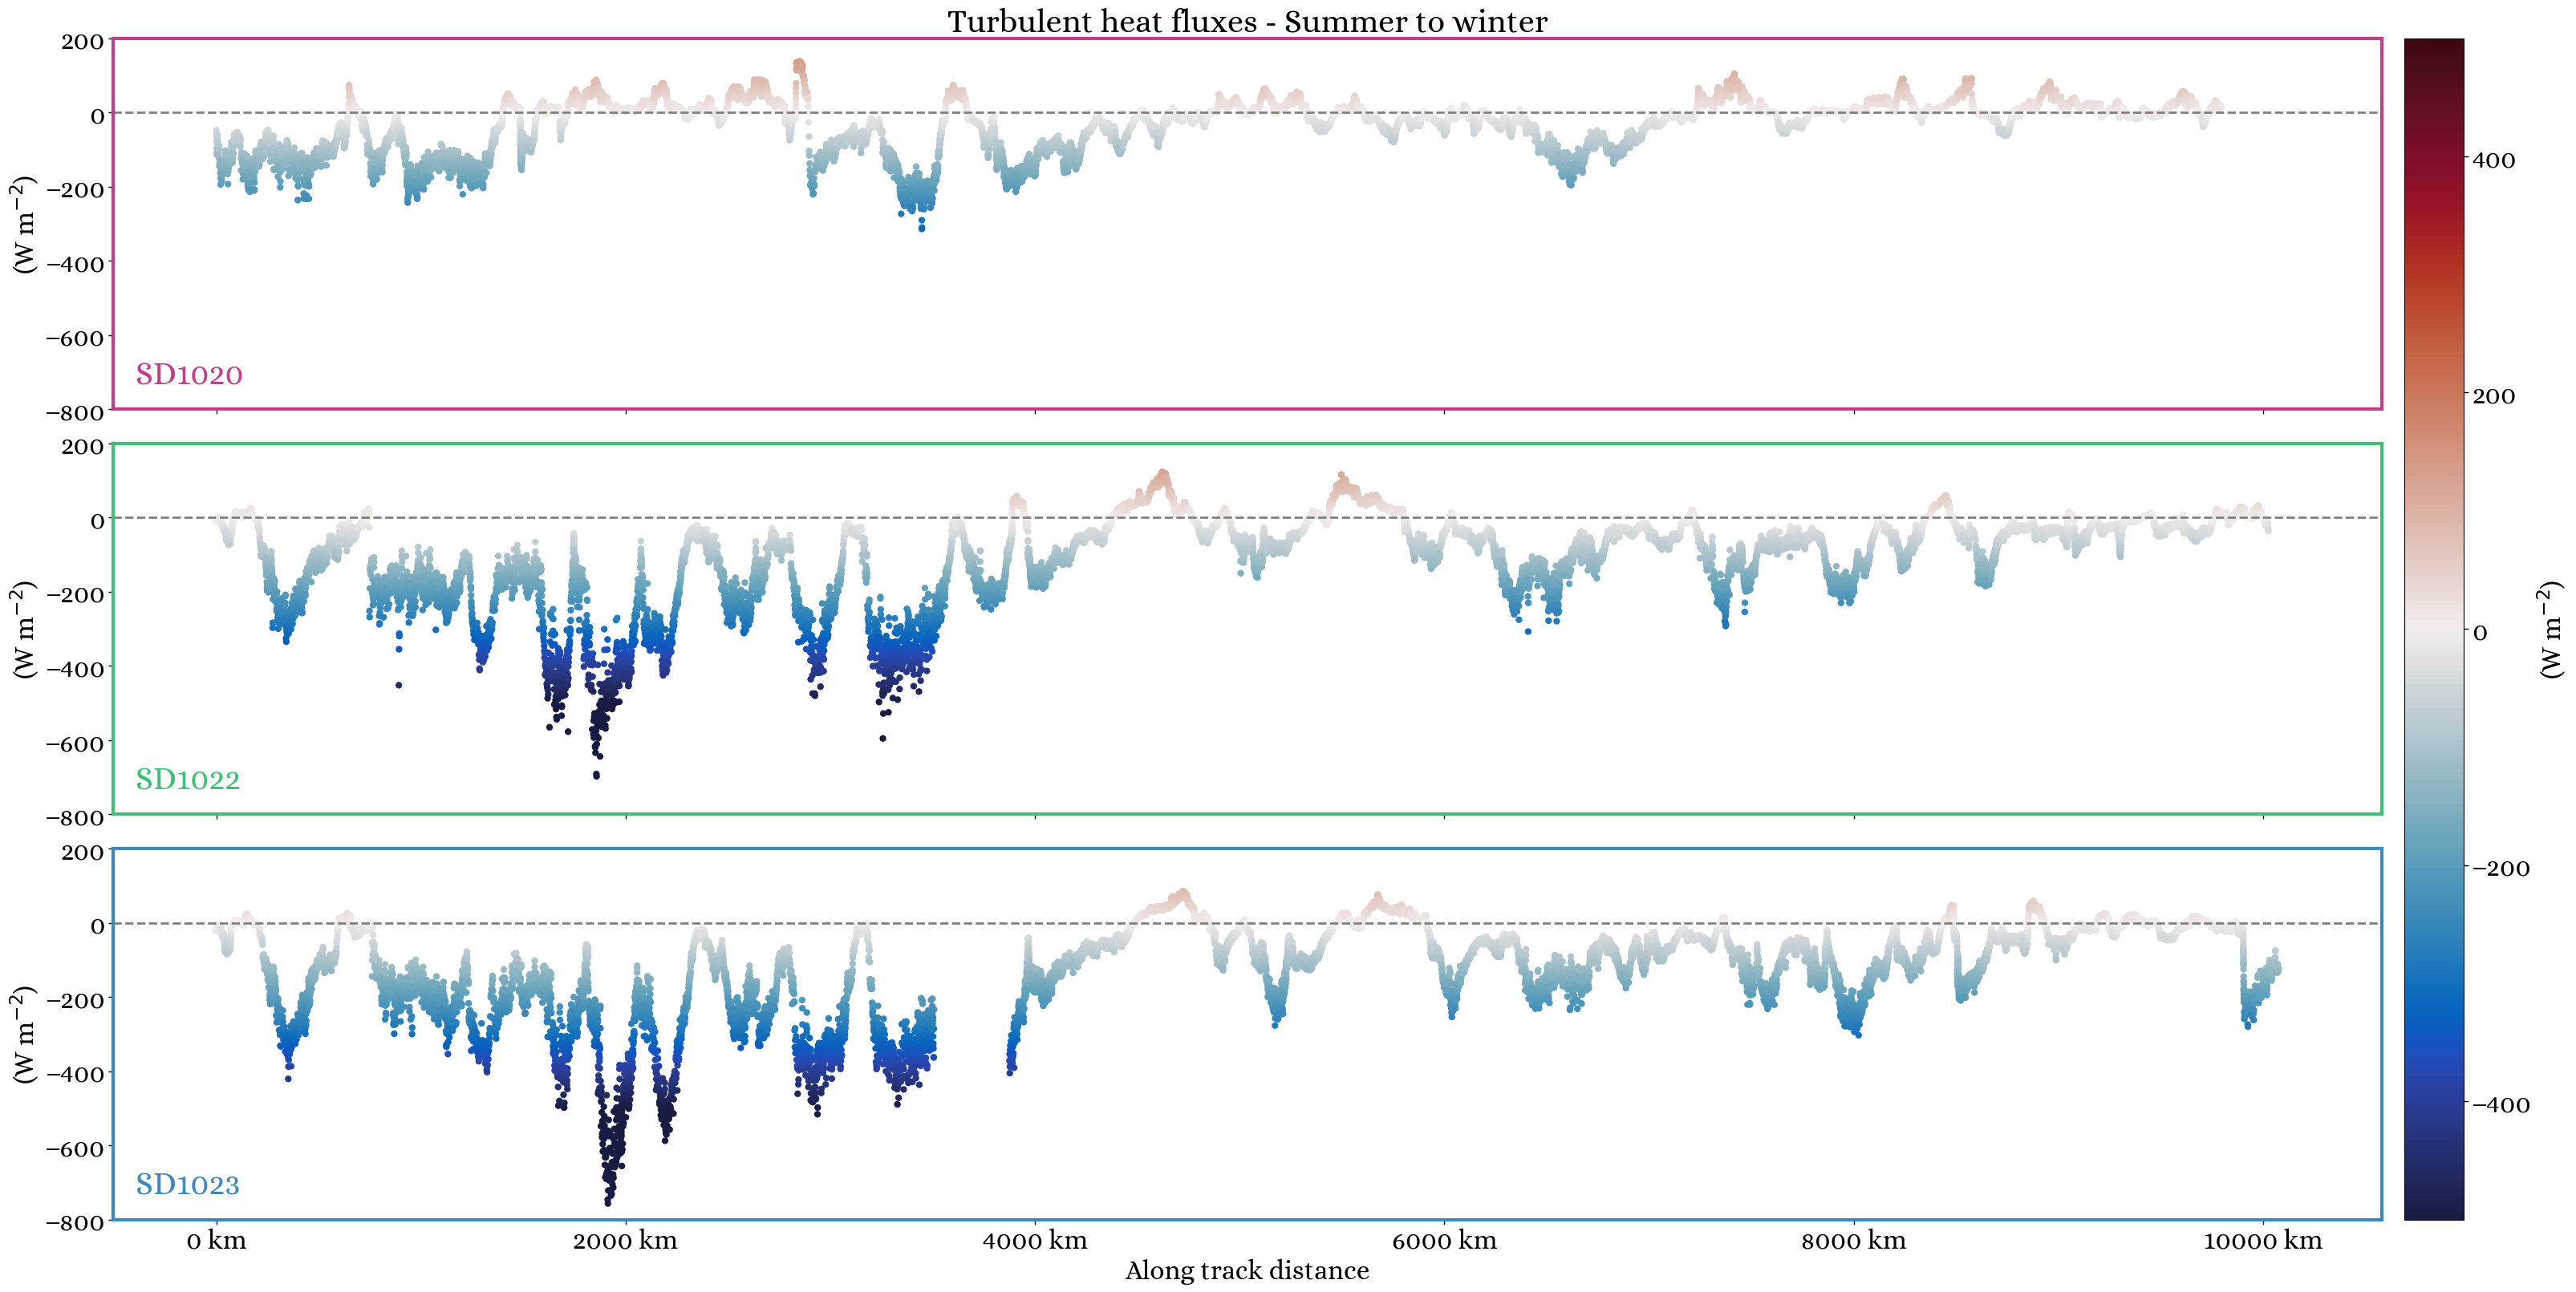

In [14]:
# Create a figure and a gridspec with two rows and two columns
fig, ax = plt.subplots(3,1,figsize=(32,16),constrained_layout=True,sharex=True)

for axs,ds,l,c in zip(ax,datasets,labels,colors):
    
    axs.axhline(0,ls='--',lw=2,c='grey')
    sct = ds.isel(time=slice(0,19126)).set_coords('distance').plot.scatter(ax=axs,
                          x='distance',
                          y='tasf', 
                          hue='tasf', 
                          ec="None", 
                          cmap="cmo.balance",
                          vmin=-500,
                          vmax=500,
                          add_colorbar=False)
    
    axs.set(xlabel="",
            ylabel="(W m$^{-2}$)",
            ylim=(-800,200))
    axs.set_title(l,loc='left',y=0.05,x=0.01,c=c)
    for spine in axs.spines.values():
        spine.set_color(c)
        spine.set_linewidth(3)

#fix_xticks(axs)
#my_funcs.rot_ticks(axs,0,ha='center')
axs.set(xlabel='Along track distance',xticks=np.arange(0,1e7+1,2e6))
axs.xaxis.set_major_formatter(FuncFormatter(km_formatter))

ax[0].set_title('Turbulent heat fluxes - Summer to winter')
plt.colorbar(sct,ax=ax,**{'pad':0.01,'label':'(W m$^{-2}$)','aspect':20})
plt.show()

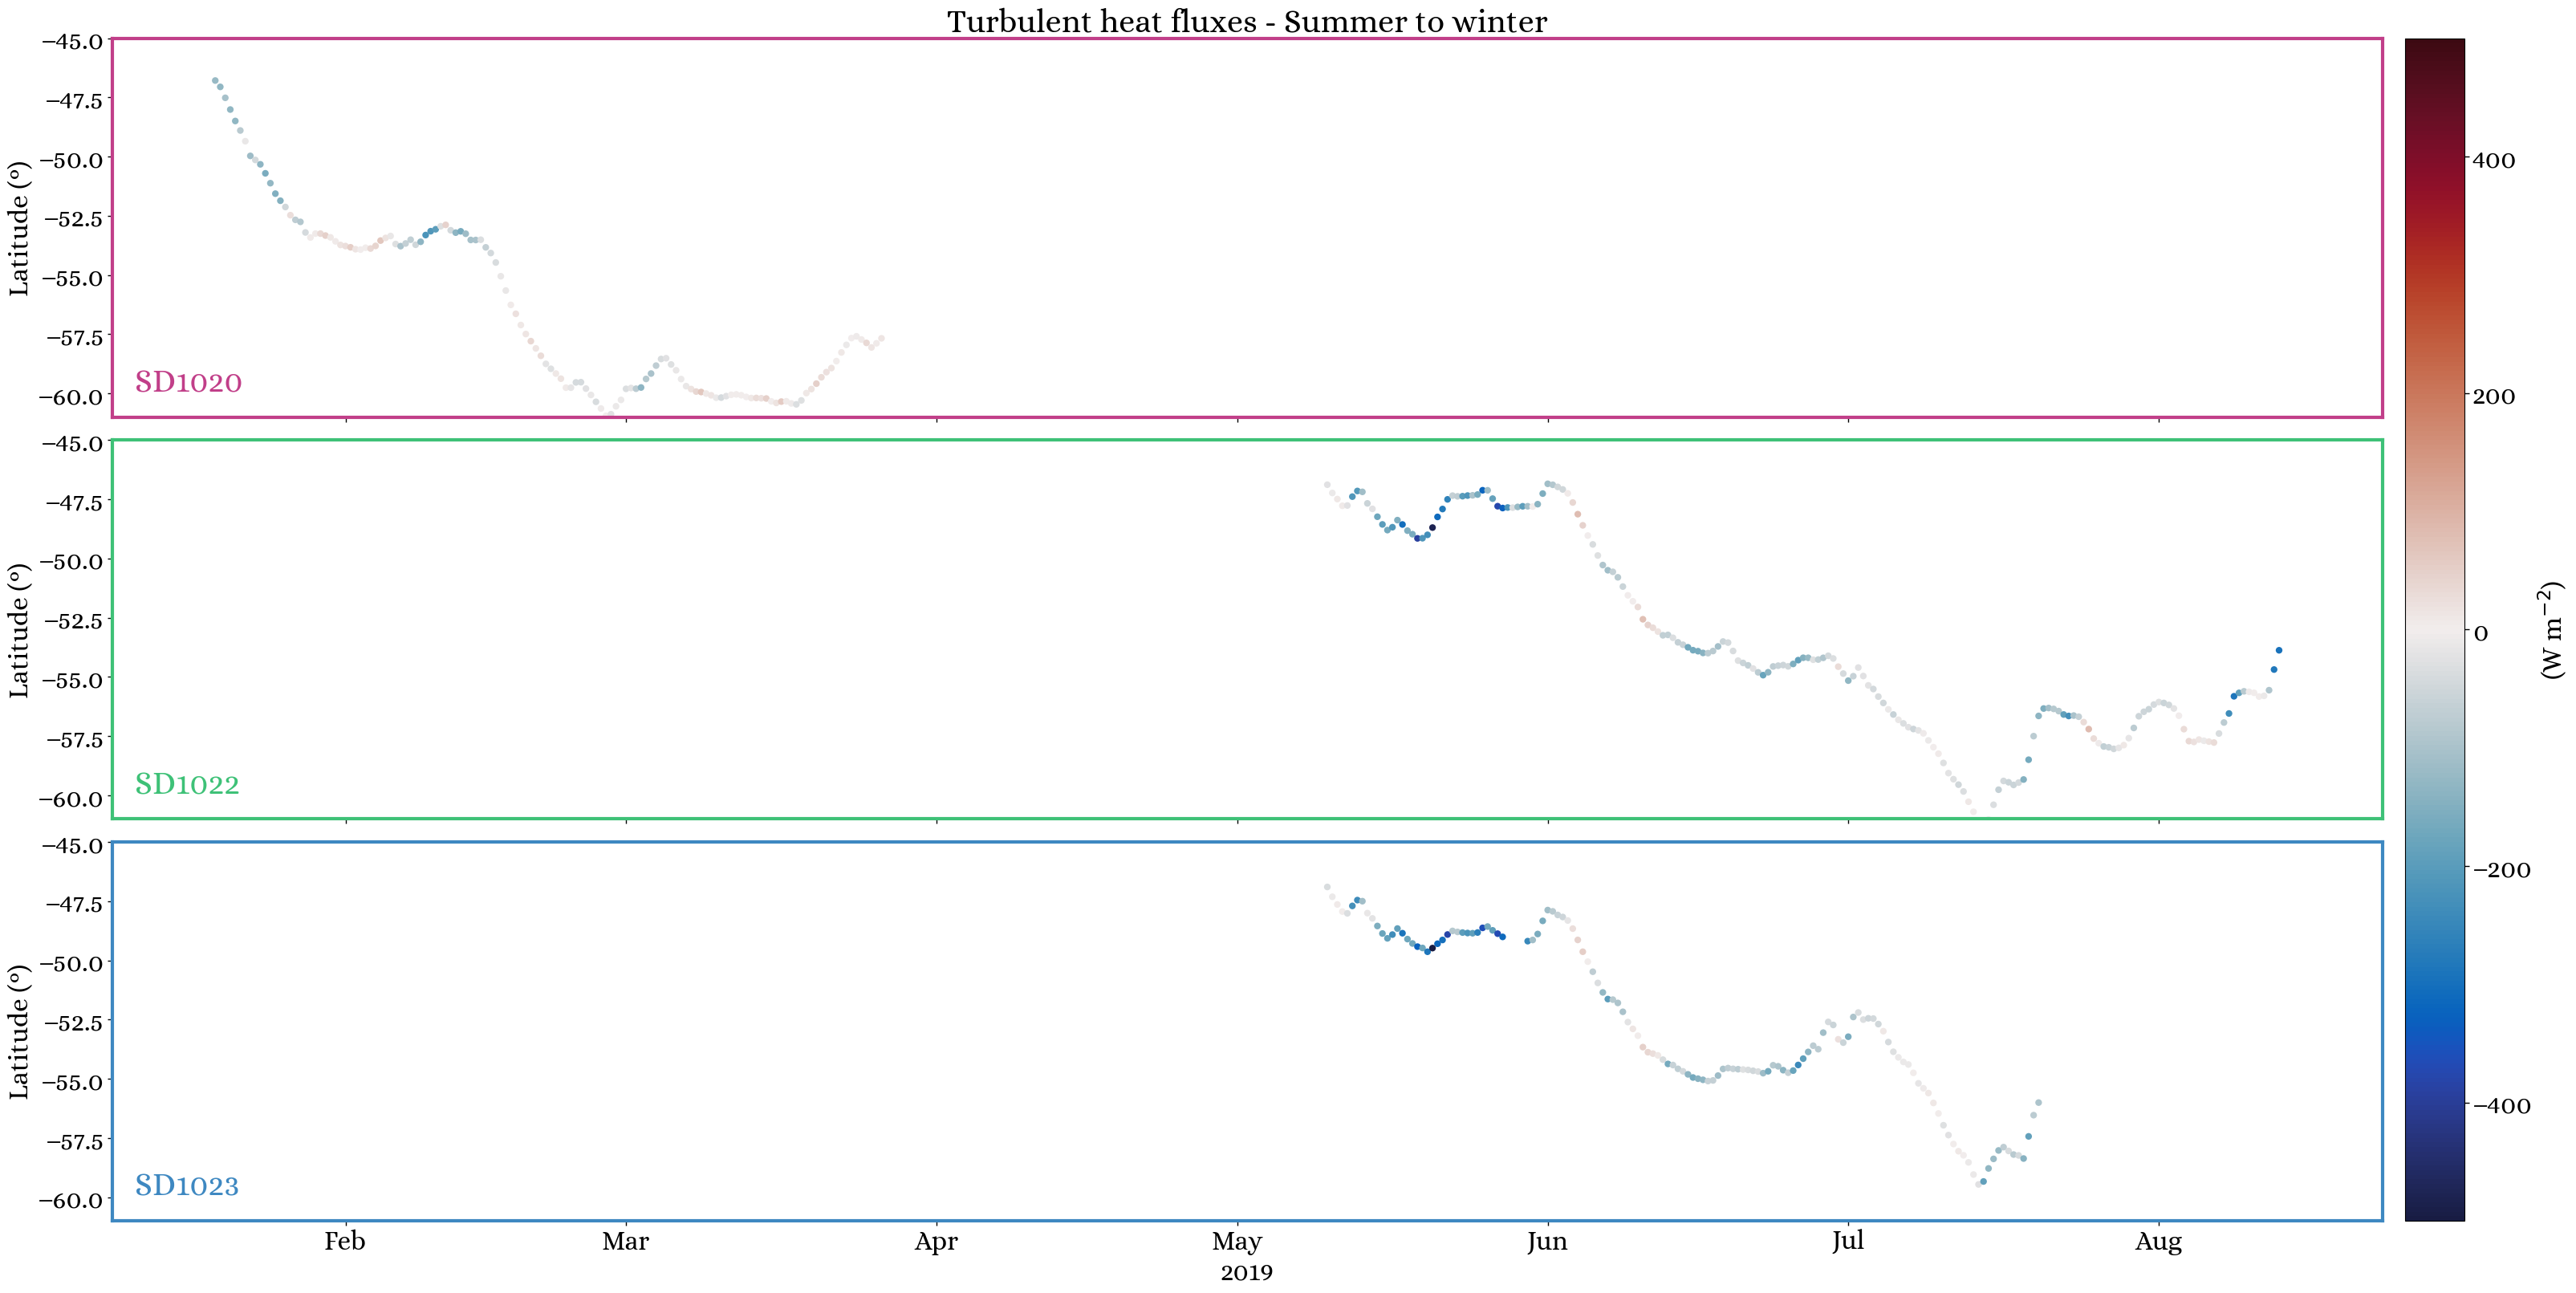

In [15]:
# Create a figure and a gridspec with two rows and two columns
fig, ax = plt.subplots(3,1,figsize=(32,16),constrained_layout=True,sharex=True)

for axs,ds,l,c in zip(ax,datasetsh,labels,colors):
    
    #axs.axhline(0,ls='--',lw=2,c='grey')
    sct = ds.plot.scatter(ax=axs,
                          x='time',
                          y='latitude', 
                          hue='tasf', 
                          ec="None", 
                          cmap="cmo.balance",
                          vmin=-500,
                          vmax=500,
                          add_colorbar=False)
    
    axs.set(xlabel="",
            ylabel="Latitude (°)",
            ylim=(-61,-45),
           )
    axs.set_title(l,loc='left',y=0.05,x=0.01,c=c)
    for spine in axs.spines.values():
        spine.set_color(c)
        spine.set_linewidth(3)

fix_xticks(axs)
my_funcs.rot_ticks(axs,0,ha='center')

ax[0].set_title('Turbulent heat fluxes - Summer to winter')
plt.colorbar(sct,ax=ax,**{'pad':0.01,'label':'(W m$^{-2}$)','aspect':20})
plt.show()

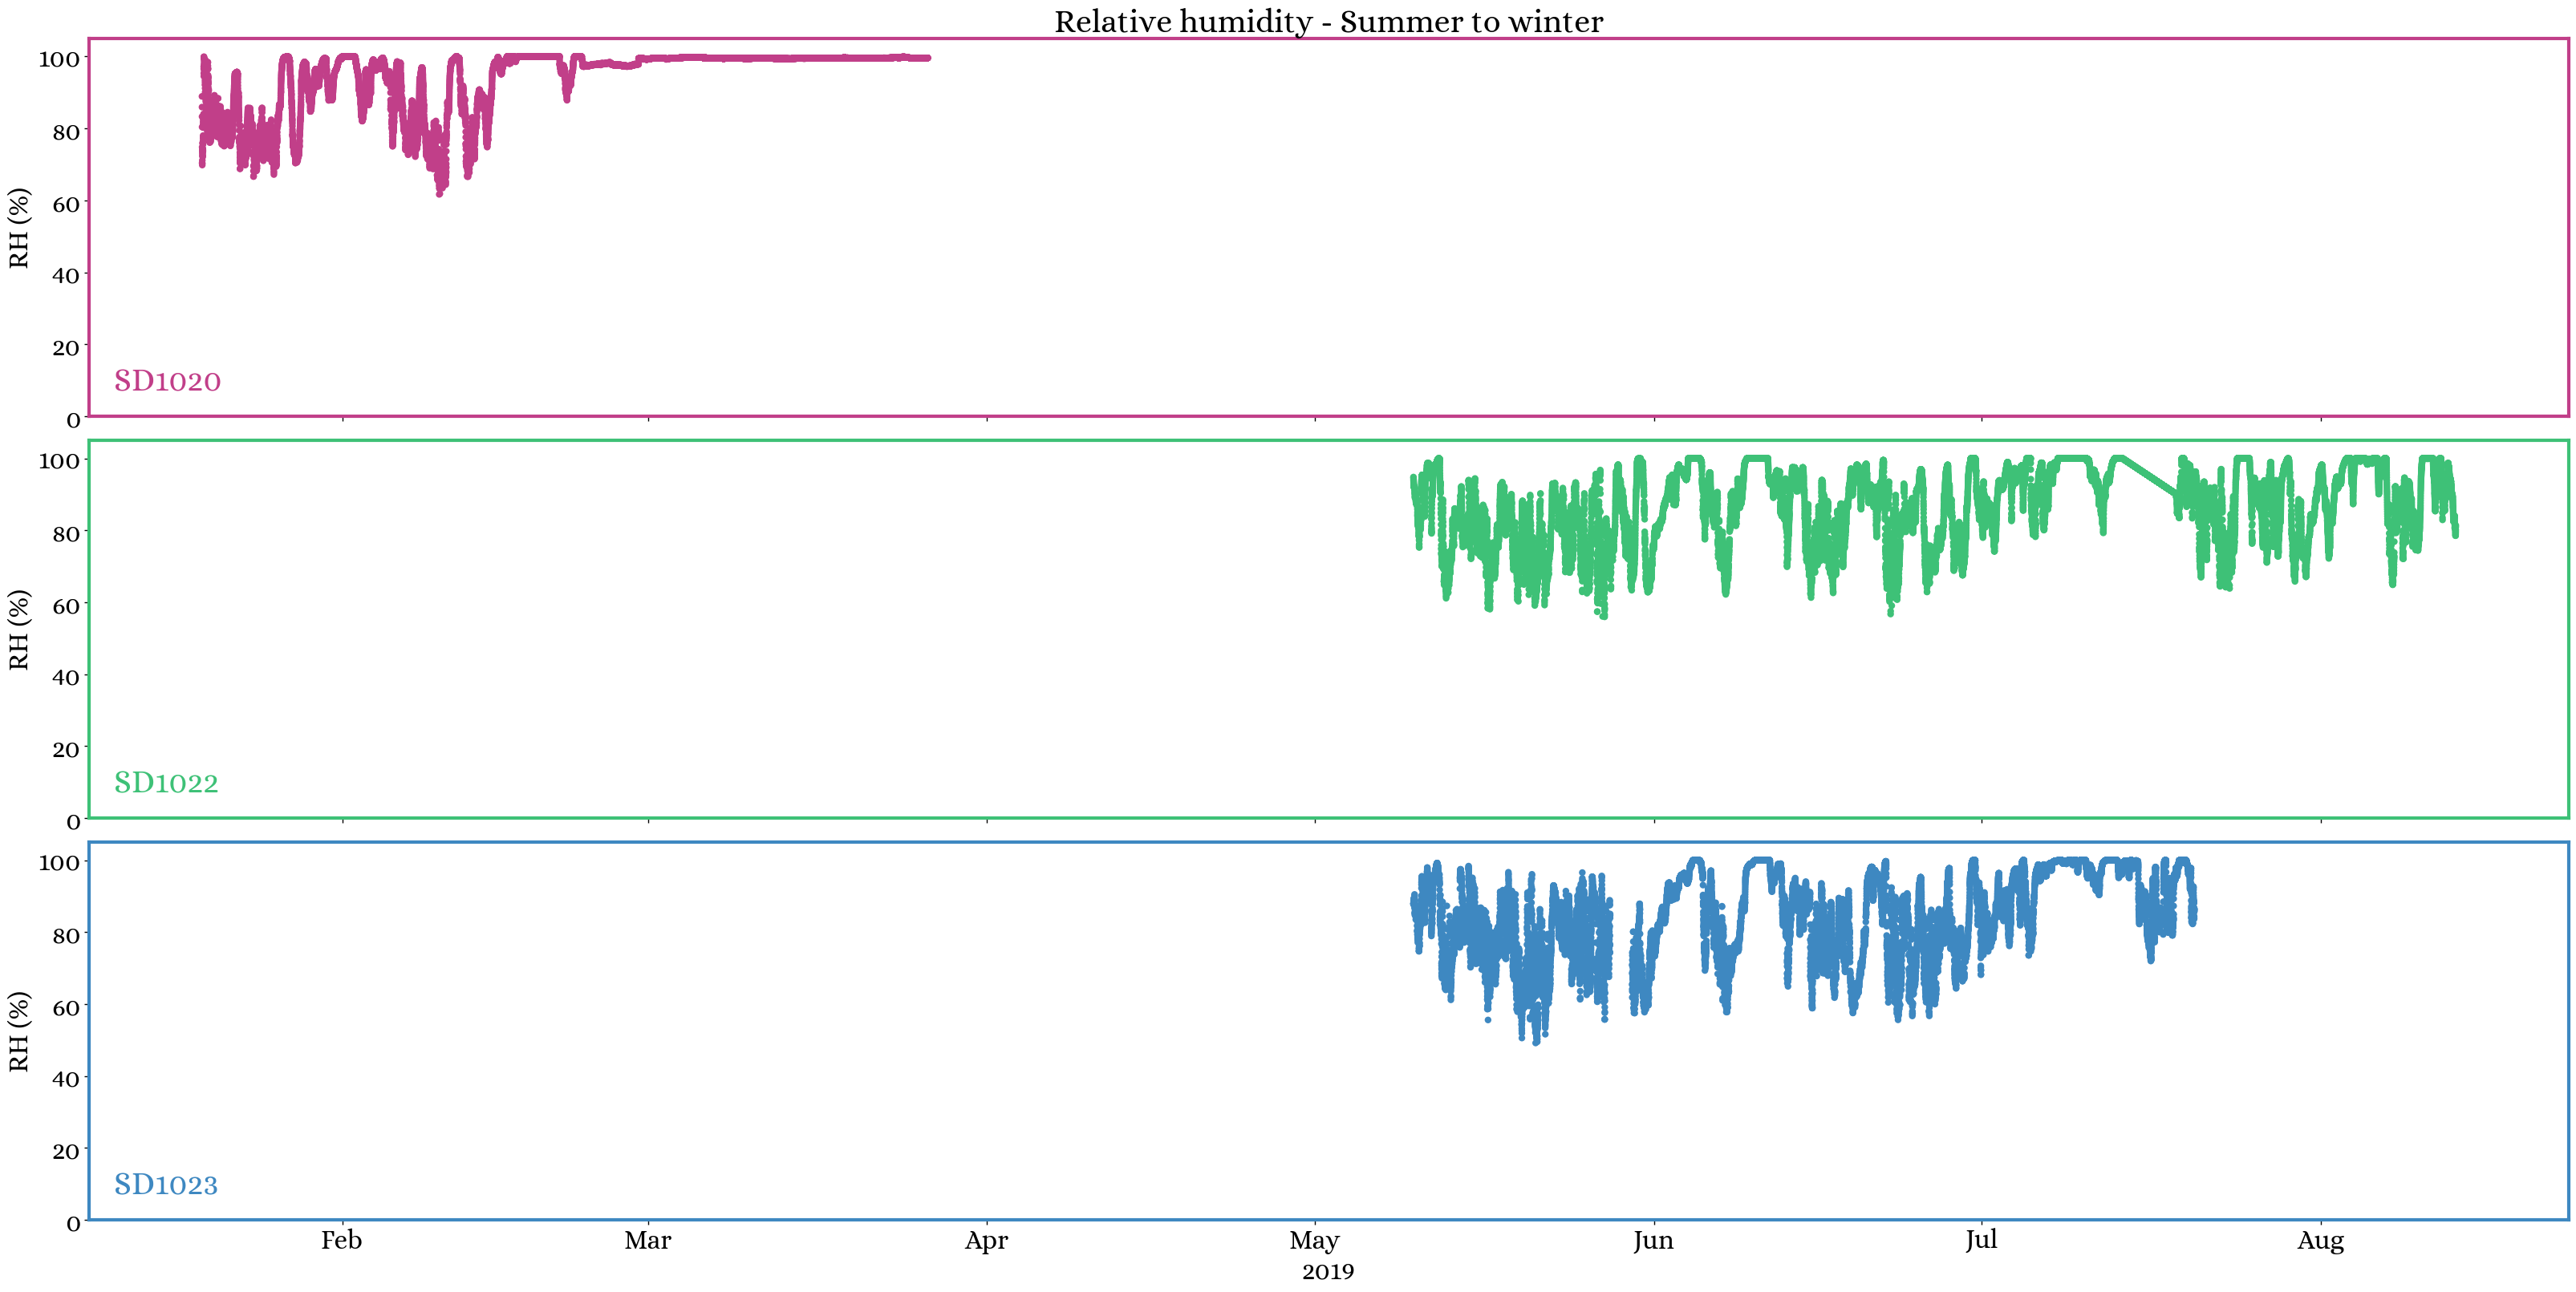

In [19]:
# Create a figure and a gridspec with two rows and two columns
fig, ax = plt.subplots(3,1,figsize=(32,16),constrained_layout=True,sharex=True)

for axs,ds,l,c in zip(ax,datasets,labels,colors):
    
    axs.axhline(0,ls='--',lw=2,c='grey')
    sct = ds.plot.scatter(ax=axs,
                          x='time',
                          y='RH_MEAN', 
                          c=c,
                          ec="None")
    
    axs.set(xlabel="",
            ylabel="RH (%)",
            ylim=(0,105))
    axs.set_title(l,loc='left',y=0.05,x=0.01,c=c)
    for spine in axs.spines.values():
        spine.set_color(c)
        spine.set_linewidth(3)

fix_xticks(axs)
my_funcs.rot_ticks(axs,0,ha='center')

ax[0].set_title('Relative humidity - Summer to winter')
plt.show()